In [1]:
! pip install duckdb


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import duckdb
import os
import pandas as pd
# Connect to DuckDB with a file path to persist data.
# This file will contain both the schema and the data.
conn = duckdb.connect(database='database.duckdb', read_only=False)
# Create a schema
sql_statement_create_schema = "CREATE SCHEMA IF NOT EXISTS real_estates;"
conn.execute(sql_statement_create_schema)
# Check if the schema has been created successfully
schemas = conn.execute("SELECT schema_name FROM information_schema.schemata;").fetchall()
print("Available schemas:", schemas)


Available schemas: [('information_schema',), ('main',), ('pg_catalog',), ('real_estates',), ('information_schema',), ('main',), ('pg_catalog',), ('information_schema',), ('main',), ('pg_catalog',)]


## ZipCode info

In [3]:
df_states_zip = pd.read_csv('df_states_zip.csv')
df_states_zip = df_states_zip[['zip_code','city','state','county','timezone','lat','lon']]

query = "CREATE TABLE IF NOT EXISTS real_estates.states_info (\
zip_code INT64 PRIMARY KEY,\
city VARCHAR,\
state VARCHAR,\
county VARCHAR,\
timezone VARCHAR,\
lat FLOAT,\
lon FLOAT);\
"
conn.execute(query)


query_insert = """
INSERT INTO real_estates.states_info VALUES (?, ?, ?, ?, ?, ?, ?);
"""
data_tuples = [tuple(row) for row in df_states_zip.values]
conn.executemany(query_insert, data_tuples)
conn.commit()

query_select = "SELECT * FROM real_estates.states_info"
conn.execute(query_select)

# Fetch and print the results
result = conn.fetchall()
for row in result[:10]:
    print(row)

(35004, 'Moody', 'AL', 'St. Clair County', 'America/Chicago', 33.60340118408203, -86.49440002441406)
(35005, 'Adamsville', 'AL', 'Jefferson County', 'America/Chicago', 33.592899322509766, -86.99400329589844)
(35006, 'Adger', 'AL', 'Jefferson County', 'America/Chicago', 33.44620132446289, -87.2229995727539)
(35007, 'Alabaster', 'AL', 'Shelby County', 'America/Chicago', 33.21870040893555, -86.78350067138672)
(35010, 'Alexander City', 'AL', 'Tallapoosa County', 'America/Chicago', 32.901100158691406, -85.91780090332031)
(35011, 'Alexander City', 'AL', 'Tallapoosa County', 'America/Chicago', 32.93939971923828, -85.94660186767578)
(35013, 'Allgood', 'AL', 'Blount County', 'America/Chicago', 33.91189956665039, -86.5093994140625)
(35014, 'Alpine', 'AL', 'Talladega County', 'America/Chicago', 33.34519958496094, -86.26570129394531)
(35015, 'Alton', 'AL', 'Jefferson County', 'America/Chicago', 33.579498291015625, -86.63760375976562)
(35016, 'Arab', 'AL', 'Marshall County', 'America/Chicago', 34.3

## State table

In [4]:
df = pd.read_parquet('num_of_houses.parquet')

# Extract unique state names from the 'State' column
unique_states = df['State'].unique()
unique_states_df = pd.DataFrame(unique_states, columns=['state_name'])
unique_states_df['state'] = ['AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN','IA',
        'KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM',
        'NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV',
        'WI','WY','PR']

# Create a new table with unique state names
conn.execute("CREATE TABLE IF NOT EXISTS real_estates.states (state_name VARCHAR PRIMARY KEY, state VARCHAR UNIQUE)")

# Insert unique state names into the new table
conn.register('unique_states_df', unique_states_df)
conn.execute("INSERT INTO real_estates.states SELECT * FROM unique_states_df")
# Verify the insertion by selecting from the new table
states = conn.execute("SELECT * FROM real_estates.states").fetchdf()
print(states)


              state_name state
0                Alabama    AL
1                 Alaska    AK
2                Arizona    AZ
3               Arkansas    AR
4             California    CA
5               Colorado    CO
6            Connecticut    CT
7               Delaware    DE
8   District of Columbia    DC
9                Florida    FL
10               Georgia    GA
11                Hawaii    HI
12                 Idaho    ID
13              Illinois    IL
14               Indiana    IN
15                  Iowa    IA
16                Kansas    KS
17              Kentucky    KY
18             Louisiana    LA
19                 Maine    ME
20              Maryland    MD
21         Massachusetts    MA
22              Michigan    MI
23             Minnesota    MN
24           Mississippi    MS
25              Missouri    MO
26               Montana    MT
27              Nebraska    NE
28                Nevada    NV
29         New Hampshire    NH
30            New Jersey    NJ
31      

## sales tax

In [5]:
cursor = conn.cursor()

data =  pd.read_csv('sales_tax.csv')
# Convert DataFrame to list of tuples
data = data[['zip_code','additional_rate','city_rate','county_rate','state_rate','total_rate']]

query = "CREATE TABLE IF NOT EXISTS real_estates.sales_tax (\
zip_code INT64 , \
additional_rate FLOAT,\
city_rate FLOAT,\
county_rate FLOAT,\
state_rate FLOAT,\
total_rate FLOAT,\
FOREIGN KEY (zip_code) REFERENCES real_estates.states_info(zip_code)\
);\
"

# FOREIGN KEY (zip_code) REFERENCES real_estates.states_info(zip_code)
cursor.execute(query)

query_insert = """
INSERT INTO real_estates.sales_tax VALUES (?, ?, ?, ?, ?, ?);"""

data_tuples = [tuple(row) for row in data.values]
cursor.executemany(query_insert, data_tuples)
conn.commit()

query_select = "SELECT * FROM real_estates.sales_tax"
cursor.execute(query_select)

# Fetch and print the results
result = cursor.fetchall()
print(result[:10])

[(35004, 0.019999999552965164, 0.03999999910593033, 0.0, 0.03999999910593033, 0.10000000149011612), (35173, 0.019999999552965164, 0.03999999910593033, 0.0, 0.03999999910593033, 0.10000000149011612), (35444, 0.0, 0.029999999329447746, 0.029999999329447746, 0.03999999910593033, 0.10000000149011612), (35634, 0.0, 0.04500000178813934, 0.009999999776482582, 0.03999999910593033, 0.0949999988079071), (35962, 0.0, 0.03999999910593033, 0.009999999776482582, 0.03999999910593033, 0.09000000357627869), (36112, 0.0, 0.03500000014901161, 0.02500000037252903, 0.03999999910593033, 0.10000000149011612), (36420, 0.0, 0.03500000014901161, 0.02500000037252903, 0.03999999910593033, 0.10000000149011612), (36583, 0.0, 0.0, 0.009999999776482582, 0.03999999910593033, 0.05000000074505806), (36849, 0.0, 0.03999999910593033, 0.009999999776482582, 0.03999999910593033, 0.09000000357627869), (99585, 0.0, 0.03999999910593033, 0.0, 0.0, 0.03999999910593033)]


## Median rental price

In [6]:
df_median = pd.read_csv('median_rent_price.csv')

query = "CREATE TABLE IF NOT EXISTS real_estates.median_rental_price (\
State VARCHAR ,\
City VARCHAR ,\
Time DATE,\
Price FLOAT,\
FOREIGN KEY (State) REFERENCES real_estates.states(state)\
);\
"
cursor.execute(query)


query_insert = """
INSERT INTO real_estates.median_rental_price VALUES (?, ?, ?, ?);
"""
cursor.executemany(query_insert, df_median.values.tolist())
conn.commit()

query_select = "SELECT * FROM real_estates.median_rental_price"
cursor.execute(query_select)

# Fetch and print the results
result = cursor.fetchall()
for row in result[:10]:
    print(row)

('CA', 'Los Angeles', datetime.date(2008, 2, 29), 470000.0)
('CA', 'Los Angeles', datetime.date(2008, 3, 31), 456000.0)
('CA', 'Los Angeles', datetime.date(2008, 4, 30), 457000.0)
('CA', 'Los Angeles', datetime.date(2008, 5, 31), 440000.0)
('CA', 'Los Angeles', datetime.date(2008, 6, 30), 435000.0)
('CA', 'Los Angeles', datetime.date(2008, 7, 31), 420000.0)
('CA', 'Los Angeles', datetime.date(2008, 8, 31), 402250.0)
('CA', 'Los Angeles', datetime.date(2008, 9, 30), 379000.0)
('CA', 'Los Angeles', datetime.date(2008, 10, 31), 370050.0)
('CA', 'Los Angeles', datetime.date(2008, 11, 30), 350000.0)


## New York and San Francisco house list

In [7]:
ny_file = 'ny.parquet'
sf_file = 'sf.parquet' 
# Use DuckDB to read the Parquet file. This creates a temporary view that you can query.
conn.execute(f"CREATE OR REPLACE VIEW my_parquet_view AS SELECT * FROM '{sf_file}'")

# Now query the data as if it was a table in a database
result = conn.execute("SELECT * FROM my_parquet_view").fetchall()

# Display the results
print(result[:3])


[({'oid': '65e4f174a8350f04b8ddde87'}, ' CA', '1024 Pacheco St,San Francisco, CA 94116', 4, 4, 2524, 2495000, '1024 Pacheco St,San Francisco', '94116'), ({'oid': '65e4f174a8350f04b8ddde88'}, ' CA', '1567 Union St,San Francisco, CA 94123', 6, 5, 4309, 7495000, '1567 Union St,San Francisco', '94123'), ({'oid': '65e4f174a8350f04b8ddde89'}, ' CA', '967 Natoma St,San Francisco, CA 94103', 1, 1, 1862, 1450000, '967 Natoma St,San Francisco', '94103')]


In [8]:
column_info = conn.execute("SELECT * FROM my_parquet_view LIMIT 0").description

# Extracting and printing column names
column_names = [col[0] for col in column_info]
print(column_names)

['_id', 'city', 'property-address', 'property-baths', 'property-beds', 'property-floorSpace', 'property-price', 'street', 'zip_code']


In [9]:
conn.execute("""
CREATE TABLE IF NOT EXISTS real_estates.sf_house_list (
    _id VARCHAR PRIMARY KEY,
    city VARCHAR,
    property_address VARCHAR,
    property_baths INTEGER,
    property_beds INTEGER,
    property_floorSpace INTEGER,
    property_price INTEGER,
    street VARCHAR,
    zip_code INT64,
    FOREIGN KEY (zip_code) REFERENCES real_estates.states_info(zip_code)
);
CREATE TABLE IF NOT EXISTS real_estates.ny_house_list (
    _id VARCHAR PRIMARY KEY,
    city VARCHAR,
    property_address VARCHAR,
    property_baths INTEGER,
    property_beds INTEGER,
    property_floorSpace INTEGER,
    property_price INTEGER,
    street VARCHAR,
    zip_code INT64,
    FOREIGN KEY (zip_code) REFERENCES real_estates.states_info(zip_code)
)
""")
conn.execute(f"COPY real_estates.ny_house_list FROM '{ny_file}' (FORMAT 'parquet')")
conn.execute(f"COPY real_estates.sf_house_list FROM '{sf_file}' (FORMAT 'parquet')")

In [10]:
# Query the ny_house_list table to see the data
query_result = conn.execute("SELECT * FROM real_estates.ny_house_list").fetchall()

# Convert the results to a Pandas DataFrame
df = pd.DataFrame(query_result, columns=[desc[0] for desc in conn.description])
# Display the DataFrame
df.head()

,_id,city,property_address,property_baths,property_beds,property_floorSpace,property_price,street,zip_code
0,{'oid': 65e4f174a8350f04b8dddde1},NY,"1074 Union St,Brooklyn, NY 11225",2,3,2000,2750000,"1074 Union St,Brooklyn",11225
1,{'oid': 65e4f174a8350f04b8dddde2},NY,"150-15 72 Road UNIT 5K,Flushing, NY 11367",1,2,1158,348000,"150-15 72 Road UNIT 5K,Flushing",11367
2,{'oid': 65e4f174a8350f04b8dddde3},NY,"162 Continental Pl #A,Staten Island, NY 10303",2,3,1100,478000,"162 Continental Pl #A,Staten Island",10303
3,{'oid': 65e4f174a8350f04b8dddde4},NY,"3322 Mickle Ave,Bronx, NY 10469",6,3,1432,595000,"3322 Mickle Ave,Bronx",10469
4,{'oid': 65e4f174a8350f04b8dddde5},NY,"160 Fordham St,Bronx, NY 10464",7,6,3000,1625000,"160 Fordham St,Bronx",10464


## Number of house, house data quantile and household income

In [11]:
num_of_house = 'num_of_houses.parquet'
combined_value = 'combined_value_quantile.parquet'
income = 'household_income.parquet'
# Use DuckDB to read the Parquet file. This creates a temporary view that you can query.
conn.execute(f"CREATE OR REPLACE VIEW my_parquet_view AS SELECT * FROM '{combined_value}'")

# Now you can query the data as if it was a table in a database
result = conn.execute("SELECT * FROM my_parquet_view").fetchall()

# Display the results
print(result[:3])


[('Alaska', 331200, 200900, 105000), ('Arizona', 455200, 336900, 232200), ('Arkansas', 602700, 402800, 262500)]


In [12]:
column_info = conn.execute("SELECT * FROM my_parquet_view LIMIT 0").description
# Extracting and printing column names
column_names = [col[0] for col in column_info]
print(column_names)

['State', 'Upper_Value', 'Median_Value', 'Lower_Value']


In [13]:
# SQL statement to create the num_of_houses table & QuantileValue
conn.execute( '''
CREATE TABLE IF NOT EXISTS real_estates.NumOfHouses (
    State VARCHAR,
    Total INTEGER,
    Less_than_50000 INTEGER,
    From_50000_to_99999 INTEGER,
    From_100000_to_149999 INTEGER,
    From_150000_to_199999 INTEGER,
    From_200000_to_299999 INTEGER,
    From_300000_to_499999 INTEGER,
    From_500000_to_999999 INTEGER,
    One_million_or_more INTEGER,
    FOREIGN KEY (State) REFERENCES real_estates.states(state_name)
);
CREATE TABLE IF NOT EXISTS real_estates.income(
    state VARCHAR(255),
    geo_id VARCHAR(255),
    total_households INT,
    less_than_10000 DECIMAL,
    between_10000_and_14999 DECIMAL,
    between_15000_and_24999 DECIMAL,
    between_25000_and_34999 DECIMAL,
    between_35000_and_49999 DECIMAL,
    between_50000_and_74999 DECIMAL,
    between_75000_and_99999 DECIMAL,
    between_100000_and_149999 DECIMAL,
    median_income DECIMAL,
    mean_income DECIMAL,
    FOREIGN KEY (state) REFERENCES real_estates.states(state_name)
  );
CREATE TABLE IF NOT EXISTS real_estates.QuantileValue (
    State VARCHAR,
    UpperValue DECIMAL(10,2),
    MedianValue DECIMAL(10,2),
    LowerValue DECIMAL(10,2),
    FOREIGN KEY (State) REFERENCES real_estates.states(state_name)
)
'''
            )
# Execute the SQL statement to create the table
conn.execute(f"COPY real_estates.NumOfHouses FROM '{num_of_house}' (FORMAT 'parquet')")
conn.execute(f"COPY real_estates.QuantileValue FROM '{combined_value}' (FORMAT 'parquet')")
conn.execute(f"COPY real_estates.income FROM '{income}' (FORMAT 'parquet')")
# Verify the table creation
tables = conn.execute("SHOW TABLES").fetchall()
print("Tables in the database:", tables)

Tables in the database: [('my_parquet_view',), ('unique_states_df',)]


In [14]:
# Query the NumOfHouses table to see the data
query_result = conn.execute("SELECT * FROM real_estates.income").fetchall()

# Convert the results to a Pandas DataFrame
df = pd.DataFrame(query_result, columns=[desc[0] for desc in conn.description])
# Display the DataFrame
df.head()

,state,geo_id,total_households,less_than_10000,between_10000_and_14999,between_15000_and_24999,between_25000_and_34999,between_35000_and_49999,between_50000_and_74999,between_75000_and_99999,between_100000_and_149999,median_income,mean_income
0,Alabama,0400000US01,2016448,7.600,5.200,9.300,8.600,12.000,16.700,12.600,14.900,59674.000,82956.000
1,Alaska,0400000US02,274574,4.400,2.500,5.400,5.300,9.100,15.800,13.200,21.800,88121.000,109524.000
2,Arizona,0400000US04,2850377,5.400,3.000,6.200,7.300,11.000,17.300,13.800,17.800,74568.000,101316.000
3,Arkansas,0400000US05,1216207,7.300,5.900,9.500,9.100,13.500,18.100,12.600,13.400,55432.000,76853.000
4,California,0400000US06,13550586,4.800,3.200,5.500,5.900,8.500,13.800,12.000,17.600,91551.000,131504.000


In [15]:
# Query the QuantileValue table to see the data
query_result = conn.execute("SELECT * FROM real_estates.QuantileValue").fetchall()

# Convert the results to a Pandas DataFrame
df = pd.DataFrame(query_result, columns=[desc[0] for desc in conn.description])
# Display the DataFrame
df.head()

,State,UpperValue,MedianValue,LowerValue
0,Alaska,331200.00,200900.00,105000.00
1,Arizona,455200.00,336900.00,232200.00
2,Arkansas,602700.00,402800.00,262500.00
3,California,290700.00,179800.00,98300.00
4,Colorado,1083100.00,715900.00,460900.00


## US economic index, interst rate data and macro estate data

In [16]:

sql_statements = """

CREATE TABLE IF NOT EXISTS real_estates.us_eco (
    date DATE PRIMARY KEY,
    gdp_value FLOAT,
    unemployment_rate FLOAT,
    inflation_rate FLOAT,
    income FLOAT
);

CREATE TABLE IF NOT EXISTS real_estates.us_interest (
    date DATE,
    interest_rate_multi_family_estate FLOAT,
    interest_rate_commercial_estate FLOAT,
    interest_owner_occupied_estate FLOAT,
    PRIMARY KEY (date),
);

CREATE TABLE IF NOT EXISTS real_estates.us_estate (
    date DATE,
    cpi FLOAT,
    permits FLOAT,
    home_sales FLOAT,
    price_index FLOAT,
    PRIMARY KEY (date),
);

"""
# FOREIGN KEY (date) REFERENCES de.us_eco(date)
try:
    # Execute the SQL statements
    conn.execute(sql_statements)
    # Commit the transaction
    conn.commit()

except Exception as e:
    # Handle any errors that occurred and print them out
    print("An error occurred:", e)



In [17]:
sql_statements = """
COPY real_estates.us_eco FROM 'us_eco.csv';
COPY real_estates.us_estate FROM 'us_estate.csv';
COPY real_estates.us_interest FROM 'us_interest.csv';
"""
conn.execute(sql_statements)
conn.commit()

In [18]:
# Query the us_eco table to see the data
query_result = conn.execute("SELECT * FROM real_estates.us_eco").fetchall()

# Convert the results to a Pandas DataFrame
df = pd.DataFrame(query_result, columns=[desc[0] for desc in conn.description])
# Display the DataFrame
df.head()

,date,gdp_value,unemployment_rate,inflation_rate,income
0,1948-07-01,279.196014,3.6,NaN,NaN
1,1983-07-01,3689.178955,9.4,NaN,5647.000000
2,1987-10-01,5007.994141,6.0,NaN,6619.600098
3,1979-04-01,2591.247070,5.8,NaN,5156.100098
4,1980-07-01,2856.482910,7.8,NaN,5189.799805


In [19]:
# Execute the SQL query to get table names
cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'real_estates'")

# Fetch the results
tables = cursor.fetchall()

# Extract the table names from the query results
table_names = [table[0] for table in tables]

# Print the table names
print("Tables in the 'real_estates' schema:", table_names)

Tables in the 'real_estates' schema: ['income', 'median_rental_price', 'NumOfHouses', 'ny_house_list', 'QuantileValue', 'sales_tax', 'sf_house_list', 'states', 'states_info', 'us_eco', 'us_estate', 'us_interest']


## Example of data query in duckDB

### Compute the house price to income ratio in New York city

To calculate the mean selling price of the house list in New York City and the mean household income in New York City to determine the household house price ratio：
1.Calculate the mean selling price of houses in New York City from the ny_house_list table.
2.Calculate the mean household income in New York from the income table.
3.Compute the house price to income ratio.

In [20]:
conn = duckdb.connect(database='database.duckdb') 

# Query to calculate the mean selling price of houses in New York City
query_mean_selling_price_ny = """
SELECT AVG(property_price) AS mean_selling_price
FROM real_estates.ny_house_list
"""

# Execute the query
mean_selling_price_result = conn.execute(query_mean_selling_price_ny).fetchall()
mean_selling_price_ny = mean_selling_price_result[0][0] if mean_selling_price_result else None

# Query to calculate the mean household income in New York
query_mean_income_ny = """
SELECT AVG(mean_income) AS mean_income
FROM real_estates.income
WHERE state = 'New York'
"""

# Execute the query
mean_income_result = conn.execute(query_mean_income_ny).fetchall()
mean_income_ny = mean_income_result[0][0] if mean_income_result else None

# Compute the house price to income ratio
if mean_selling_price_ny and mean_income_ny:
    house_price_income_ratio = mean_selling_price_ny / mean_income_ny
    print(f"Mean Selling Price in New York City: {mean_selling_price_ny}")
    print(f"Mean Household Income in New York City: {mean_income_ny}")
    print(f"Household House Price Ratio in New York City: {house_price_income_ratio}")
else:
    print("Could not calculate the ratio due to missing data.")

# Close the connection
conn.close()

Mean Selling Price in New York City: 946309.1463414634
Mean Household Income in New York City: 119130.0
Household House Price Ratio in New York City: 7.943499927318588


### Relation of the median rental price in California and the US GDP

In [21]:
conn = duckdb.connect(database='database.duckdb') 
query = """
SELECT
    eco.date AS eco_date,
    mrp.Time AS rental_date,
    eco.gdp_value,
    mrp.Price
FROM
    real_estates.median_rental_price mrp
LEFT JOIN LATERAL (
    SELECT date, gdp_value
    FROM real_estates.us_eco
    WHERE date <= mrp.Time
    ORDER BY date DESC
    LIMIT 1
) eco ON TRUE
WHERE
    mrp.State = 'CA'
"""

result = conn.execute(query).fetchall()

# Check if the result is not empty and convert it to a pandas DataFrame
if result:
    df = pd.DataFrame(result, columns=['Eco_Date', 'Rental_Date', 'GDP_Value', 'Median_Rental_Price'])
    print(df)
else:
    print("No matching data found.")

        Eco_Date Rental_Date     GDP_Value  Median_Rental_Price
0     2008-04-01  2008-04-30  14865.701172             283500.0
1     2008-10-01  2008-10-31  14608.208984             251500.0
2     2008-01-01  2008-02-29  14706.538086             279000.0
3     2008-07-01  2008-07-31  14898.999023             265000.0
4     2008-01-01  2008-03-31  14706.538086             260000.0
...          ...         ...           ...                  ...
6106  2019-01-01  2019-01-31  21104.132812             600000.0
6107  2020-01-01  2020-02-29  21706.513672             831500.0
6108  2018-10-01  2018-10-31  20917.867188             625000.0
6109  2018-04-01  2018-04-30  20580.912109             625000.0
6110  2018-07-01  2018-09-30  20798.730469             625000.0

[6111 rows x 4 columns]


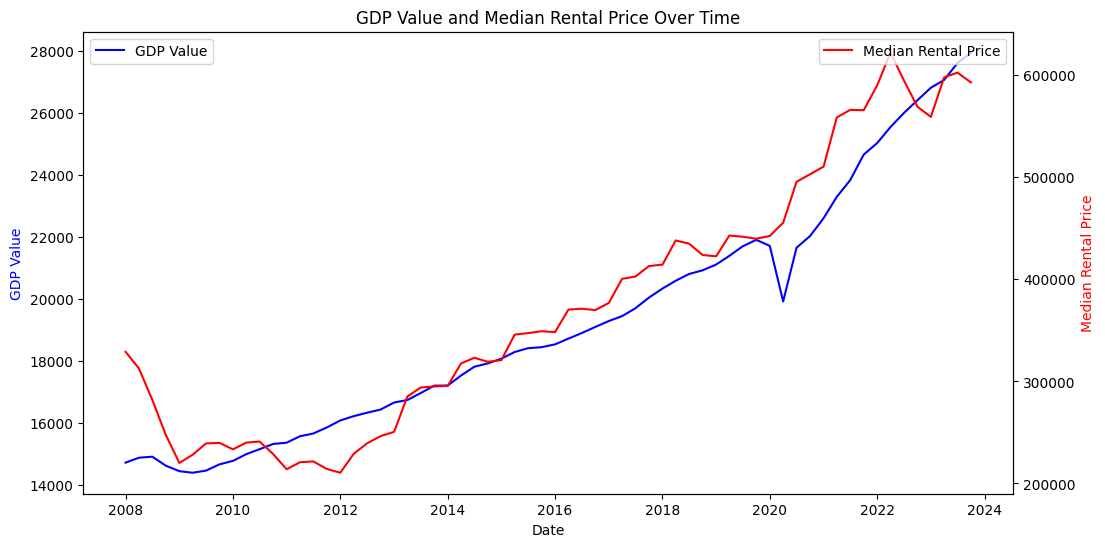

In [22]:
import matplotlib.pyplot as plt

# Convert 'Eco_Date' to datetime 
df['Eco_Date'] = pd.to_datetime(df['Eco_Date'])

# Group by 'Eco_Date' and calculate the mean of the 'Median_Rental_Price'
df_agg = df.groupby('Eco_Date').agg({'GDP_Value':'mean', 'Median_Rental_Price':'mean'}).reset_index()

# Plotting the graph with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()
ax1.plot(df_agg['Eco_Date'], df_agg['GDP_Value'], label='GDP Value', color='blue')
ax2.plot(df_agg['Eco_Date'], df_agg['Median_Rental_Price'], label='Median Rental Price', color='red')

# Titles and labels
ax1.set_xlabel('Date')
ax1.set_ylabel('GDP Value', color='blue')
ax2.set_ylabel('Median Rental Price', color='red')

# Legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.title('GDP Value and Median Rental Price Over Time')
plt.show()
